## NoSQL

Вернёмся к датасету публикаций о коронавирусе. Извлечём из датасета информацию о веществах и заболеваниях, и положим результаты в СУБД MongoDB.

In [24]:
import pandas as pd

df = pd.read_csv('c:/users/dmitr/downloads/metadata.csv.zip')
df['publish_time'] = pd.to_datetime(df['publish_time'])
df

c:\winapp\conda\lib\site-packages\IPython\core\interactiveshell.py:3398: DtypeWarning: Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1056655,aeuy92bx,d86cfba423427426c10fa9092748733f5c7ca7e0; a8e5...,BioRxiv; MedRxiv; WHO,Potent neutralization of 2019 novel coronaviru...,10.1101/2020.02.01.929976,NaN,NaN,medrxiv,"2019-nCoV, which is a novel coronavirus emerge...",2020-02-02,"Lei, Changhai; Fu, Wenyan; Qian, Kewen; Li, Ti...",bioRxiv,NaN,NaN,NaN,document_parses/pdf_json/d86cfba423427426c10fa...,NaN,https://doi.org/10.1101/2020.02.01.929976,211121242.0
1056656,n8hlrknq,b98985f125c3391aac709332e6380fe8b11ef6e5,Elsevier; Medline; PMC,"Molecular-based diagnostics, including future ...",10.1016/j.mpmed.2013.08.012,PMC7108438,32288574.0,no-cc,Microbiology laboratories have traditionally r...,2013-10-28,"Goldenberg, Simon",Medicine (Abingdon),NaN,NaN,NaN,document_parses/pdf_json/b98985f125c3391aac709...,document_parses/pmc_json/PMC7108438.xml.json,https://api.elsevier.com/content/article/pii/S...,214756712.0
1056657,05dxn54t,0d1698212a1fcbbed2ffff38953397b3fb82f30d,Medline; PMC,A Patient With Bilateral Conjunctivitis Positi...,10.1097/ico.0000000000002485,PMC7446980,32794685.0,no-cc,To present a patient with bilateral conjunctiv...,2020-07-02,"Sirakaya, Ender; Sahiner, Mustafa; Aslan Sirak...",Cornea,NaN,NaN,NaN,document_parses/pdf_json/0d1698212a1fcbbed2fff...,document_parses/pmc_json/PMC7446980.xml.json,https://www.ncbi.nlm.nih.gov/pubmed/32794685/;...,221122247.0
1056658,zpeij14g,9b2bbb5ceb21084931b5de7e0d60633e524a20bb,Medline; PMC,Incidental lowering of otitis-media complaints...,10.1007/s00431-020-03747-9,PMC7370867,32691131.0,no-cc,Given COVID-19 pandemic periodic outpatient as...,2020-07-20,"Torretta, Sara; Capaccio, Pasquale; Coro, Ilar...",Eur J Pediatr,NaN,NaN,NaN,documen

Для извлечение сущностей используем spacy, как и в одной из предыдущих лекций:

In [2]:
import spacy
nlp = spacy.load("en_ner_bc5cdr_md")

Для работы с MongoDB установим соответствующую библиотеку `pymongo`:

In [3]:
import sys
!{sys.executable} -m pip install pymongo

In [25]:
from pymongo import MongoClient

CONNECTION_STRING = "mongodb://localhost"
 
client = MongoClient(CONNECTION_STRING)
db = client['cord']
db_papers = db['papers']

In [32]:
import numpy as np
from tqdm.auto import tqdm
tqdm.pandas()

for i,x in tqdm(df.iterrows(),total=df.shape[0]):
    if x['abstract'] is np.nan or x['authors'] is np.nan:
        continue
    jdoc = { 
        "title" : x['title'], "abstract" : x['abstract'], 
        "publish_time" : x['publish_time'], "journal" : x['journal'] 
        }
    jdoc['authors'] = [
        a.strip()
        for a in x['authors'].split(';')]
    jdoc['sources'] = [
        a.strip()
        for a in x['source_x'].split(';')]
    doc = nlp(x['abstract'])
    jdoc['DISEASES'] = list(set([
        e.text.lower()
        for e in doc.ents
        if e.label_ == 'DISEASE'    
    ]))
    jdoc['CHEMICALS'] = list(set([
        e.text.lower()
        for e in doc.ents
        if e.label_ == 'CHEMICAL'    
    ]))
    db_papers.insert_one(jdoc)

  0%|          | 0/1056660 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [39]:
def query(q):
    return pd.DataFrame(db_papers.find(q))

query({ 'DISEASES' : 'sars'})

,_id,title,abstract,publish_time,journal,authors,sources,DISEASES,CHEMICALS
0,64615cbefb056b3e977e6f98,Managing emerging infectious diseases: Is a fe...,In the 1980's and 1990's HIV/AIDS was the emer...,2004-11-19,Aust New Zealand Health Policy,"[Howse, Genevieve]",[PMC],"[communicable diseases, anthrax, sars, infecti...",[]
1,64615cbffb056b3e977e6fa3,Australian public health policy in 2003 – 2004,"In Australia, compared with other developed co...",2005-04-06,Aust New Zealand Health Policy,"[Lin, Vivian, Robinson, Priscilla]",[PMC],"[sars, communicable disease]",[]
2,64615cbffb056b3e977e6fa5,Globalization and Health,This debut editorial of Globalization and Heal...,2005-04-22,Global Health,"[Martin, Greg]",[PMC],"[predilection, sars, human disease, aids, fatt...",[]
3,64615cbffb056b3e977e6fb4,On pandemics and the duty to care: whose duty?...,BACKGROUND: As a number of commentators have n...,2006-04-20,BMC Med Ethics,"[Ruderman, Carly, Tracy, C Shawn, Bensimon, Cé...",[PMC],"[infectious disease, sars, infectious diseases...",[]
4,64615cc1fb056b3e977e6fcb,Pandemic influenza preparedness: an ethical fr...,BACKGROUND: Planning for the next pandemic inf...,2006-12-04,BMC Med Ethics,"[Thompson, Alison K, Faith, Karen, Gibson, Jen...",[PMC],"[sars, collateral damage, pandemic]",[pandemic]
...,...,...,...,...,...,...,...,...,...
403,6461ddb9fb056b3e977f60b4,An Analysis of 38 Pregnant Women with COVID-19...,"The emergence of a novel coronavirus, termed S...",2020-03-17,Archives of pathology & laboratory medicine,"[Schwartz, David A]",[Medline],"[coronavirus infections, mers, respiratory dis...","[sars-cov-2, covid-19]"
404,6461ddbffb056b3e977f6114,Modeling the Transmission of Covid-19: Impact ...,BACKGROUND Schools are an integral part of the...,2021-04-30,Journal of public health management and practi...,"[Miller, Gabrielle F, Greening, Bradford, Rice...",[Medline],"[sars, infection]","[covidtracer, sars-cov-2, covid-19]"
405,6461ddc3fb056b3e977f6166,Lack of evidence of avian adenovirus infection...,Zoonotic infections constitute a major public ...,2009-01-01,Journal of agromedicine,"[Kayali, Ghazi, Ortiz, Ernesto J, Chorazy, Mar...",[Medline],"[respiratory syndrome, sars, infection, adenov...",[]
406,6461ddc8fb056b3e977f61d8,Absence of infection in asymptomatic contacts ...,The first case of severe acute respiratory syn...,2006-01-01,Euro surveillance : bulletin Europeen sur les ...,"[Le Vu, S, Yazdanpanah, Y, Bitar, D, Emmanuell...",[Medline],"[sars infection, sars, sars coronavirus immuno...",[]


In [43]:
from datetime import datetime

query({ 'DISEASES' : 'sars', 'publish_time' : { '$gte' : datetime(2020,1,1)} })

,_id,title,abstract,publish_time,journal,authors,sources,DISEASES,CHEMICALS
0,64615e98fb056b3e977e91bf,Antioxidant molecular mechanism of adenosyl ho...,"An antioxidant molecule namely, adenosyl homoc...",2020-01-27,Mol Biol Rep,"[Sarkar, Purabi, Stefi, Raju V., Pasupuleti, M...",[PMC],"[sars, hars]","[trolox, adenosyl, spirulina, no, abts, sulphur]"
1,64615ecefb056b3e977e9563,Mathematically modeling spillovers of an emerg...,Modeling the behavior of zoonotic pandemic thr...,2020-08-26,PLoS One,"[Royce, Katherine, Fu, Feng]",[PMC],"[zoonotic disease, zoonotic disease mutating, ...",[]
2,64615f0ffb056b3e977e992d,Supercomputer-Based Ensemble Docking Drug Disc...,We present a supercomputer-driven pipeline for...,2020-07-29,ChemRxiv,"[Acharya, Atanu, Agarwal, Rupesh, Baker, Matth...",[PMC],[sars],"[ai, supercomputer-driven]"
3,64615f47fb056b3e977e9c2a,Fast Identification of Possible Drug Treatment...,The recent outbreak of novel coronavirus disea...,2020-02-21,ChemRxiv,"[Wang, Junmei]",[PMC],"[sars, hcv, coronavirus disease]","[his41, −13.82, carfilzomib, streptomycin, cov..."
4,64616008fb056b3e977ea770,Treatment of ARS deficiencies with specific am...,PURPOSE: Recessive cytosolic aminoacyl-tRNA sy...,2021-06-30,Genet Med,"[Kok, Gautam, Tseng, Laura, Schene, Imre F., D...",[PMC],"[temporal deficiencies, sars, infections, ars,...","[amino acid, seryl-rs, phenylalanyl-rs-beta-su..."
...,...,...,...,...,...,...,...,...,...
146,6461dd98fb056b3e977f5f90,Current Drugs with Potential for Treatment of ...,PURPOSE SARS-CoV-2 first emerged in China in D...,2020-01-01,Journal of pharmacy & pharmaceutical sciences ...,"[Md Insiat Islam Rabby,]",[Medline],"[mers, respiratory syndrome, malaria, sars, in...",[covid-19]
147,6461dda1fb056b3e977f5fcd,A case of bradycardia during SARS CoV-2 infect...,BACKGROUND Severe acute respiratory syndrome c...,2021-03-24,Infectious diseases,"[Kilicaslan, Onder, Isancli, Didem Kizmaz, Ulu...",[Medline],"[cardiological disorder, infectious disease, s...",[sars-cov-2]
148,6461ddb9fb056b3e977f60b4,An Analysis of 38 Pregnant Women with COVID-19...,"The emergence of a novel coronavirus, termed S...",2020-03-17,Archives of pathology & laboratory medicine,"[Schwartz, David A]",[Medline],"[coronavirus infections, mers, respiratory dis...","[sars-cov-2, covid-19]"
149,6461ddbffb056b3e977f6114,Modeling the Transmission of Covid-19: Impact ...,BACKGROUND Schools are an integral part of the...,2021-04-30,Journal of public health management and practi...,"[Miller, Gabrielle F, Greening, Bradford, Rice...",[Medline],"[sars, infection]","[covidtracer, sars-cov-2, covid-19]"


In [49]:
pd.DataFrame(
    db_papers.aggregate([
    {
        '$addFields': {
            'year': {
                '$year': '$publish_time'
            }
        }
    }, {
        '$group': {
            '_id': '$year', 
            'number': {
                '$count': {}
            }
        }
    }, {
        '$sort': {
            'number': -1
        }
    }]))

,_id,number
0,2021,21719
1,2020,14815
2,2022,10103
3,2019,1936
4,2018,1375
...,...,...
56,1956,1
57,1964,1
58,1952,1
59,1962,1


<AxesSubplot:xlabel='year,month'>

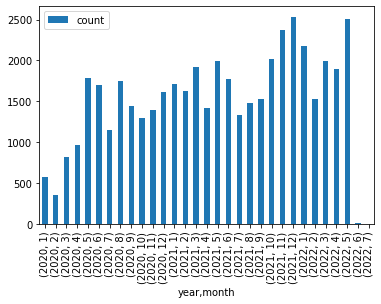

In [50]:
pd.DataFrame(db_papers.aggregate(
    [
    {
        '$addFields': {
                'year' : { '$year': '$publish_time' },
                'month' : { '$month' : '$publish_time'}
        }
    }, {
        '$group': {
            '_id': { 'year': '$year', 'month' : '$month' }, 
            'num': {
                '$count': {}
            }
        }
    }, {
        '$project': {
            'year': '$_id.year',
            'month': '$_id.month',
            'count' : '$num'
        }
    },
    { '$match' : { 'year' : { '$gte' : 2020} }},
    { '$sort' : { 'year' : 1, 'month' : 1 }}
]
)).drop(columns="_id").set_index(['year','month']).plot(kind='bar')